In [1]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import *

In [2]:
spark.sparkContext.setLogLevel("INFO")

In [3]:
spark = SparkSession.builder \
.appName('projeto') \
.master('local[*]') \
.config('spark.driver.memory','64G') \
.config('spark.sql.execution.arrow.pyspark.enabled', True) \
.config('spark.ui.showConsoleProgress', True) \
.enableHiveSupport()\
.getOrCreate()

In [4]:
spark

## 1 - Enviar os dados para o hdfs
### No Terminal:
#### cp /home/marcelo/Downloads/projeto/* /home/marcelo/Treinamento/docker-bigdata/spark/input/arquivos

#### docker exec -it namenode bash
#### hdfs dfs -mkdir /user/marcelo/projeto_semantix
#### hdfs dfs -moveFromLocal /input/arquivos/*.csv user/marcelo/projeto_semantix

In [5]:
# Listando arquivos no HDFS
!hdfs dfs -ls /user/marcelo/projeto_semantix

Found 7 items
-rw-r--r--   3 root supergroup   62493275 2022-08-08 12:41 /user/marcelo/projeto_semantix/HIST_PAINEL_COVIDBR_2020_Parte1_07ago2022.csv
-rw-r--r--   3 root supergroup   76520606 2022-08-08 12:41 /user/marcelo/projeto_semantix/HIST_PAINEL_COVIDBR_2020_Parte2_07ago2022.csv
-rw-r--r--   3 root supergroup   91120853 2022-08-08 12:41 /user/marcelo/projeto_semantix/HIST_PAINEL_COVIDBR_2021_Parte1_07ago2022.csv
-rw-r--r--   3 root supergroup   93414239 2022-08-08 12:41 /user/marcelo/projeto_semantix/HIST_PAINEL_COVIDBR_2021_Parte2_07ago2022.csv
-rw-r--r--   3 root supergroup   91807916 2022-08-08 12:41 /user/marcelo/projeto_semantix/HIST_PAINEL_COVIDBR_2022_Parte1_07ago2022.csv
-rw-r--r--   3 root supergroup   19367488 2022-08-08 12:41 /user/marcelo/projeto_semantix/HIST_PAINEL_COVIDBR_2022_Parte2_07ago2022.csv
drwxr-xr-x   - root supergroup          0 2022-08-08 22:44 /user/marcelo/projeto_semantix/view2


-------------

## 2 - Otimizar todos os dados do hdfs para uma tabela Hive particionada por município.

In [6]:
## Criando Schema para ler os dados no formato correto
schema = StructType().add("regiao", "string").add("estado", "string").add("municipio", "string")\
.add("coduf", "integer").add("codmun", "integer").add("codRegiaoSaude", "integer").add("nomeRegiaoSaude", "string")\
.add("data", "timestamp").add("semanaEpi", "integer").add("populacaoTCU2019", "integer")\
.add("casosAcumulado", "integer").add("casosNovos", "integer").add("obitosAcumulado", "integer")\
.add("obitosNovos", "integer").add("Recuperadosnovos", "integer").add("emAcompanhamentoNovos", "integer")\
.add("interior/metropolitana", "integer")

In [7]:
# Lendo os Dados, ajustando e mostrando o Schema
df = spark.read.csv("/user/marcelo/projeto_semantix/*.csv", header="true", sep=";", schema=schema)
df = df.withColumn('data', from_unixtime(unix_timestamp(df.data), "yyyy-MM-dd"))
df.printSchema()

root
 |-- regiao: string (nullable = true)
 |-- estado: string (nullable = true)
 |-- municipio: string (nullable = true)
 |-- coduf: integer (nullable = true)
 |-- codmun: integer (nullable = true)
 |-- codRegiaoSaude: integer (nullable = true)
 |-- nomeRegiaoSaude: string (nullable = true)
 |-- data: string (nullable = true)
 |-- semanaEpi: integer (nullable = true)
 |-- populacaoTCU2019: integer (nullable = true)
 |-- casosAcumulado: integer (nullable = true)
 |-- casosNovos: integer (nullable = true)
 |-- obitosAcumulado: integer (nullable = true)
 |-- obitosNovos: integer (nullable = true)
 |-- Recuperadosnovos: integer (nullable = true)
 |-- emAcompanhamentoNovos: integer (nullable = true)
 |-- interior/metropolitana: integer (nullable = true)



In [8]:
# Visualizando Databases existentes
spark.sql("show Databases").show()

+------------+
|databaseName|
+------------+
|    castilho|
|       covid|
|     default|
|       views|
+------------+



In [9]:
# Criando Nova Database e salvando no formato tabela Hive
spark.sql("create database covid")
df.write.mode('overwrite').partitionBy('municipio').format('csv')\
.saveAsTable('covid.municipio', path='hdfs://namenode:8020/user/hive/warehouse/covid/')


In [10]:
spark.sql('show partitions covid.municipio').show(10,truncate = False)

+-----------------------------+
|partition                    |
+-----------------------------+
|municipio=Abadia de Goiás    |
|municipio=Abadia dos Dourados|
|municipio=Abadiânia          |
|municipio=Abaetetuba         |
|municipio=Abaeté             |
|municipio=Abaiara            |
|municipio=Abaré              |
|municipio=Abatiá             |
|municipio=Abaíra             |
|municipio=Abdon Batista      |
+-----------------------------+
only showing top 10 rows



In [11]:
# Conferindo no HDFS se está tudo OK
!hdfs dfs -ls /user/hive/warehouse/covid |head -5

Found 5299 items
-rw-r--r--   2 root supergroup          0 2022-08-08 13:15 /user/hive/warehouse/covid/_SUCCESS
drwxr-xr-x   - root supergroup          0 2022-08-08 13:15 /user/hive/warehouse/covid/municipio=Abadia de Goiás
drwxr-xr-x   - root supergroup          0 2022-08-08 13:15 /user/hive/warehouse/covid/municipio=Abadia dos Dourados
drwxr-xr-x   - root supergroup          0 2022-08-08 13:15 /user/hive/warehouse/covid/municipio=Abadiânia


## 3. Criar as 3 vizualizações pelo Spark com os dados enviados para o HDFS:
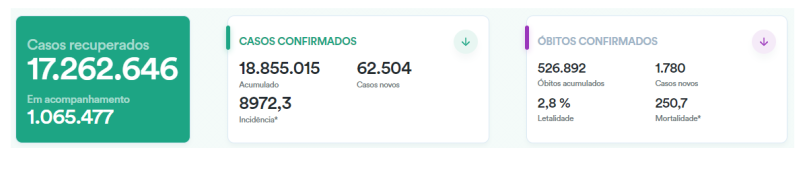

In [12]:
# Criando visualizações do dia 06/07/2021
data = "2021-07-06"
dia6 = df.where((df.regiao == 'Brasil') & (df.data == data))

In [13]:
# Primeira Visualização

view1 = dia6.select(col("Recuperadosnovos").alias("Casos Recuperados")\
                    ,col("emAcompanhamentoNovos").alias("Em Acompanhamento"))
view1.show()

+-----------------+-----------------+
|Casos Recuperados|Em Acompanhamento|
+-----------------+-----------------+
|         17151673|          1115726|
+-----------------+-----------------+



In [14]:
# Segunda Visualização

view2 = dia6.select(col('casosAcumulado').alias('Casos_Acumulados'),\
                     col('casosNovos').alias('Casos_Novos'),\
                    (round(col('casosAcumulado') / col('populacaoTCU2019')*100000,1)).alias('Incidência'))
view2.show()

+----------------+-----------+----------+
|Casos_Acumulados|Casos_Novos|Incidência|
+----------------+-----------+----------+
|        18855015|      62504|    8972.3|
+----------------+-----------+----------+



In [15]:
# Terceira Visualização

view3 = dia6.select(dia6['obitosAcumulado'].alias('Obitos_Acumulados'),\
                      dia6['obitosNovos'].alias('Obitos_Novos'),\
                     (round(dia6['obitosAcumulado']/dia6['casosAcumulado']*100,1)).alias('Letalidade'),\
                     (round(dia6['obitosAcumulado']/dia6['populacaoTCU2019']*100000,1)).alias('Mortalidade'))
view3.show()

+-----------------+------------+----------+-----------+
|Obitos_Acumulados|Obitos_Novos|Letalidade|Mortalidade|
+-----------------+------------+----------+-----------+
|           526892|        1780|       2.8|      250.7|
+-----------------+------------+----------+-----------+



In [16]:
# Criando cópia
view3_1 = view3

---------------

## 4. Salvar a primeira visualização como tabela Hive

In [17]:
# Salvando
view1.write.mode("overwrite").saveAsTable("castilho.view1", format="hive")

In [18]:
# Verificando
!hdfs dfs -ls /user/hive/warehouse/castilho.db/view1

Found 2 items
-rwxr-xr-x   2 root supergroup          0 2022-08-08 22:50 /user/hive/warehouse/castilho.db/view1/part-00000-0fb90c48-135f-4e07-b8a4-d32eb30b9463-c000
-rwxr-xr-x   2 root supergroup         17 2022-08-08 22:50 /user/hive/warehouse/castilho.db/view1/part-00003-0fb90c48-135f-4e07-b8a4-d32eb30b9463-c000


-----------

## 5. Salvar a segunda visualização com formato parquet e compressão snappy

In [19]:
# Salvando
view2.write.mode("overwrite").parquet("/user/marcelo/projeto_semantix/view2", compression="snappy")

In [20]:
# Verificando
!hdfs dfs -ls /user/marcelo/projeto_semantix/view2

Found 3 items
-rw-r--r--   2 root supergroup          0 2022-08-08 22:51 /user/marcelo/projeto_semantix/view2/_SUCCESS
-rw-r--r--   2 root supergroup        475 2022-08-08 22:51 /user/marcelo/projeto_semantix/view2/part-00000-f12cb3cd-20af-49c1-a008-b8d43d90d155-c000.snappy.parquet
-rw-r--r--   2 root supergroup        918 2022-08-08 22:51 /user/marcelo/projeto_semantix/view2/part-00003-f12cb3cd-20af-49c1-a008-b8d43d90d155-c000.snappy.parquet


--------------

## 6 - Salvar a terceira visualização em um tópico no Kafka

In [21]:
# Salvando
view3.selectExpr("to_json(struct(*)) AS value")\
.write.format('kafka').option('kafka.bootstrap.servers', 'kafka:9092')\
.option('topic', 'obitos_acumulados').save()

In [22]:
# Verificando
view3 = spark.read.format('kafka')\
.option('kafka.bootstrap.servers', 'kafka:9092')\
.option('subscribe','obitos_acumulados').load()

view3_kafka = view3.select(col('value').cast('string'))
view3_kafka.show(1, truncate = False)

+-------------------------------------------------------------------------------------+
|value                                                                                |
+-------------------------------------------------------------------------------------+
|{"Obitos_Acumulados":526892,"Obitos_Novos":1780,"Letalidade":2.8,"Mortalidade":250.7}|
+-------------------------------------------------------------------------------------+
only showing top 1 row



-----------------

## 7. Criar a visualização pelo Spark com os dados enviados para o HDFS:
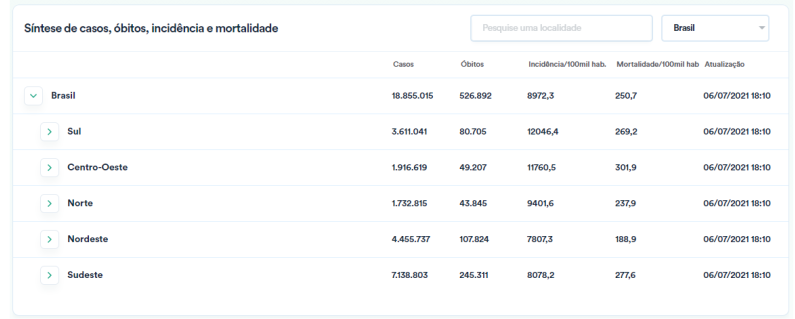

In [23]:
# Fazendo as Agregações
view4_agg = df.groupBy(['regiao'])\
.agg({'casosAcumulado':'max', 'obitosAcumulado':'max', 'populacaoTCU2019':'max'})

In [24]:
# Renomeando 
view4_rename = view4_agg.withColumnRenamed("regiao", "Região")\
.withColumnRenamed("max(casosAcumulado)", "Casos").withColumnRenamed("max(obitosAcumulado)", "Óbitos")\
.withColumnRenamed("max(populacaoTCU2019)", "pop")

In [25]:
# Incluindo "Mortalidade" e "Incidencia" ao DF
view4 = view4_rename.withColumn("Incidencia", round(col("Casos") / col("pop")*100000,1))\
.withColumn("Mortalidade", round(view4_rename["Óbitos"]/view4_rename["pop"]*100000,1))\
.drop("pop").dropna("all")
view4.sort(col("Região").desc())

DataFrame[Região: string, Casos: int, Óbitos: int, Incidencia: double, Mortalidade: double]

In [26]:
# Visualizando
view4.sort(col("Região").asc()).show(truncate = False)

+------------+--------+------+----------+-----------+
|Região      |Casos   |Óbitos|Incidencia|Mortalidade|
+------------+--------+------+----------+-----------+
|Brasil      |34018371|679996|16187.9   |323.6      |
|Centro-Oeste|1643044 |27228 |23410.7   |388.0      |
|Nordeste    |1668570 |30449 |11218.7   |204.7      |
|Norte       |817817  |18569 |9506.3    |215.8      |
|Sudeste     |5949473 |173338|12956.4   |377.5      |
|Sul         |2704589 |44645 |23654.0   |390.5      |
+------------+--------+------+----------+-----------+



-----------------------

## 8. Salvar a visualização do exercício 6 em um tópico no Elastic

In [27]:
# Instalando requisitos
!pip install elasticsearch==7.9

In [28]:
from elasticsearch import Elasticsearch

In [29]:
# Criando Conexão
es = Elasticsearch('172.18.0.1:9200')

In [30]:
es.info(pretty=True)

{'name': 'node1',
 'cluster_name': 'my_cluster',
 'cluster_uuid': 'mkcQJPI5QdCggVLbaLLT_A',
 'version': {'number': '7.9.2',
  'build_flavor': 'default',
  'build_type': 'docker',
  'build_hash': 'd34da0ea4a966c4e49417f2da2f244e3e97b4e6e',
  'build_date': '2020-09-23T00:45:33.626720Z',
  'build_snapshot': False,
  'lucene_version': '8.6.2',
  'minimum_wire_compatibility_version': '6.8.0',
  'minimum_index_compatibility_version': '6.0.0-beta1'},
 'tagline': 'You Know, for Search'}

In [31]:
view3_1.show(3)

+-----------------+------------+----------+-----------+
|Obitos_Acumulados|Obitos_Novos|Letalidade|Mortalidade|
+-----------------+------------+----------+-----------+
|           526892|        1780|       2.8|      250.7|
+-----------------+------------+----------+-----------+



In [32]:
# Mudando tipos de dados
view3_es = view3_1.withColumn("Letalidade", col("Letalidade").cast(FloatType()))\
                     .withColumn("Mortalidade", col("Mortalidade").cast(FloatType()))

In [33]:
# Salvando
view3_es.write.format("es") \
                .option("es.nodes", "172.18.0.1") \
                .option("es.port", '9200')\
                .option("es.resource", 'view3') \
                .option("es.nodes.wan.only", "true") \
                .mode('overwrite')\
                .save()

In [34]:
# Verificando
es.search(index="view3")

{'took': 0,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 1, 'relation': 'eq'},
  'max_score': 1.0,
  'hits': [{'_index': 'view3',
    '_type': '_doc',
    '_id': 'eGGof4IBLfygdaBMhhn5',
    '_score': 1.0,
    '_source': {'Obitos_Acumulados': 526892,
     'Obitos_Novos': 1780,
     'Letalidade': 2.8,
     'Mortalidade': 250.7}}]}}